In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [48]:
DATA_FOLDER = 'ts_csvs'
env_folders = {
    "KeyCorridorS3R3": "s3", # KeyCorridorS3R3 | no test with old random method (only with normal distrubution)
    "KeyCorridorS4R3": "s4", # KeyCorridorS4R3
    "KeyCorridorS6R3": "s6", # KeyCorridorS6R3
    "MultiRoom-N10-S6": "room", # MultiRoom-N10-S6
    "ObstructedMaze-2Q": "maze", # ObstructedMaze-2Q
    # "Framestack_KeyCorrS4R3": "framestack", # On KeyCorridorS4R3, testing different framestack sizes
}

tick_labels = {
    "KeyCorridorS3R3": (np.arange(0, 1100, 333), ["0", "10M", "20M", "30M"]), # KeyCorridorS3R3 | no test with old random method (only with normal distrubution)
    "KeyCorridorS4R3": (np.arange(0, 1100, 200), ["0", "10M", "20M", "30M", "40M", "50M"]), # KeyCorridorS4R3
    "KeyCorridorS6R3": (np.arange(0, 1100, 200), ["0", "20M", "40M", "60M", "80M", "100M"]), # KeyCorridorS6R3
    "MultiRoom-N10-S6": (np.arange(0, 1100, 250), ["0", "10M", "20M", "30M", "40M"]), # MultiRoom-N10-S6
    "ObstructedMaze-2Q": (np.arange(0, 1100, 200), ["0", "20M", "40M", "60M", "80M", "100M"]), # ObstructedMaze-2Q
    "Framestack_KeyCorrS4R3": (np.arange(0, 1100, 200), ["0", "10M", "20M", "30M", "40M", "50M"]), # On KeyCorridorS4R3, testing different framestack sizes
}

ORIGINAL = "oldFalse_normalFalse"
NEW = "oldTrue_normalFalse"
NEWNORMAL = "oldFalse_normalTrue"

# fetch csv files from a given directory and its subdirectories and return a list of file paths
def get_csv_files(dir_path):
    csv_files = []
    for root, dirs, files in os.walk(dir_path):
        for file in files:
            if file.endswith(".csv"):
                csv_files.append(os.path.join(root, file))
    return csv_files

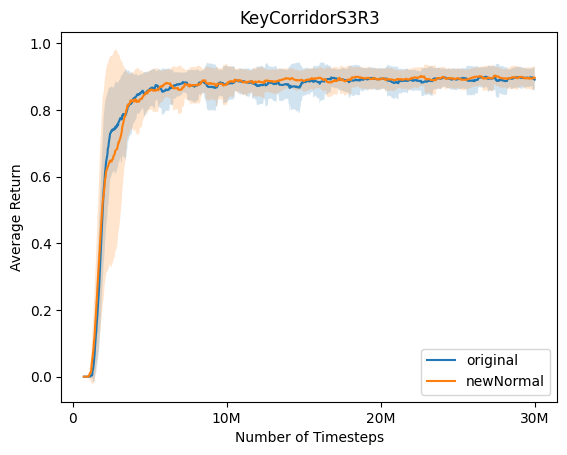

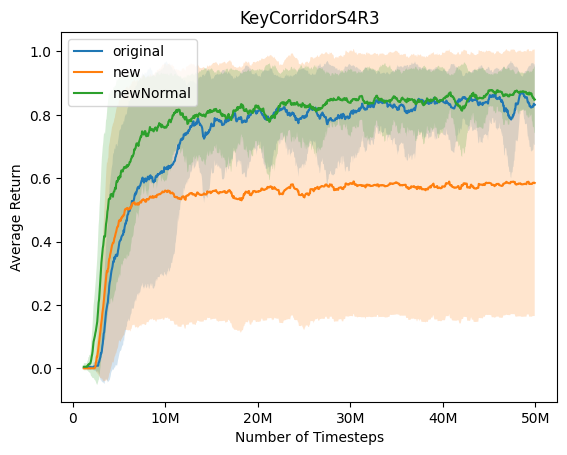

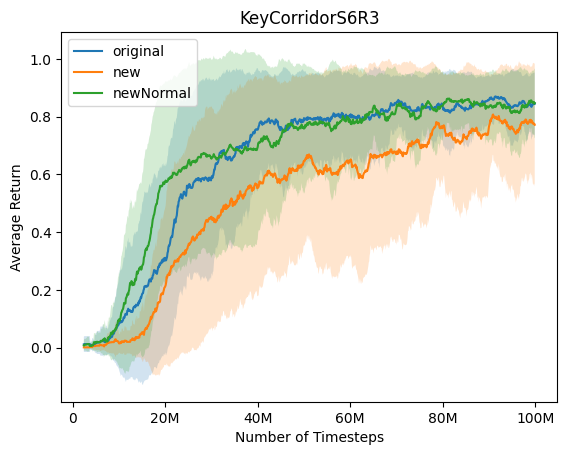

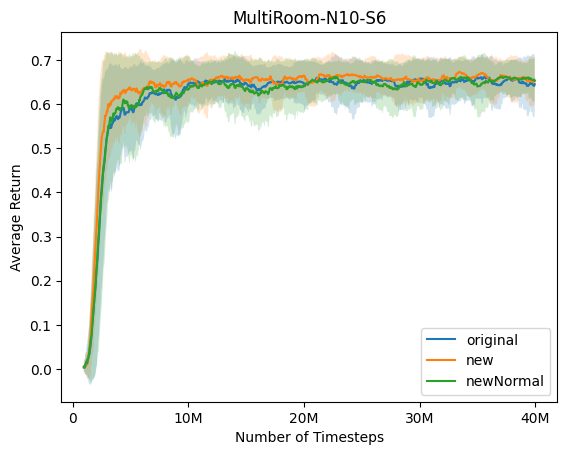

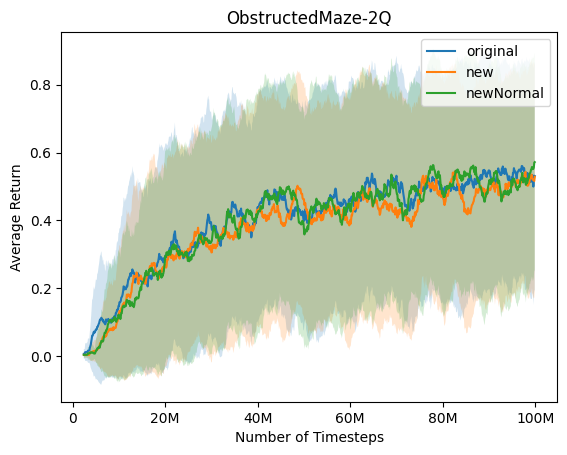

In [58]:
SMOOTHING = 25

for exp_name, folder in env_folders.items():
    results = {
        "original": [],
        "new": [],
        "newNormal": [],
    }
    mean_std = {}

    csv_files = get_csv_files(os.path.join(DATA_FOLDER, folder))
    for csv_file in csv_files:
        if ORIGINAL in csv_file:
            results["original"].append(pd.read_csv(csv_file, header=0, names=["wall_time", "step", "reward"])["reward"])
        elif NEW in csv_file:
            results["new"].append(pd.read_csv(csv_file, header=0, names=["wall_time", "step", "reward"])["reward"])
        elif NEWNORMAL in csv_file:
            results["newNormal"].append(pd.read_csv(csv_file, header=0, names=["wall_time", "step", "reward"])["reward"])

    mean_std = {}
    for key, value in results.items():
        if key == "new" and exp_name == "KeyCorridorS3R3": # no old new method for KeyCorridorS3R3
            continue
        mean_std[key] = (
            pd.Series(np.mean(value, axis=0)).rolling(SMOOTHING).mean(),
            pd.Series(np.std(value, axis=0)).rolling(SMOOTHING).mean()
        )

    plt.plot(mean_std["original"][0], label="original")
    plt.fill_between(range(len(mean_std["original"][0])),mean_std["original"][0] - mean_std["original"][1],mean_std["original"][0] + mean_std["original"][1],alpha=0.2)
    if exp_name != "KeyCorridorS3R3":
        plt.plot(mean_std["new"][0], label="new") 
        plt.fill_between(range(len(mean_std["new"][0])),mean_std["new"][0] - mean_std["new"][1],mean_std["new"][0] + mean_std["new"][1],alpha=0.2) if exp_name != "KeyCorridorS3R3" else None
    plt.plot(mean_std["newNormal"][0], label="newNormal")
    plt.fill_between(range(len(mean_std["newNormal"][0])),mean_std["newNormal"][0] - mean_std["newNormal"][1],mean_std["newNormal"][0] + mean_std["newNormal"][1],alpha=0.2)
    plt.legend()
    plt.ylabel("Average Return")
    plt.xlabel("Number of Timesteps")
    # plt.xlim(0, 4000)
    plt.xticks(*tick_labels[exp_name])
    plt.title(exp_name)
    plt.savefig(f"{exp_name}.png", dpi=300)
    plt.show()


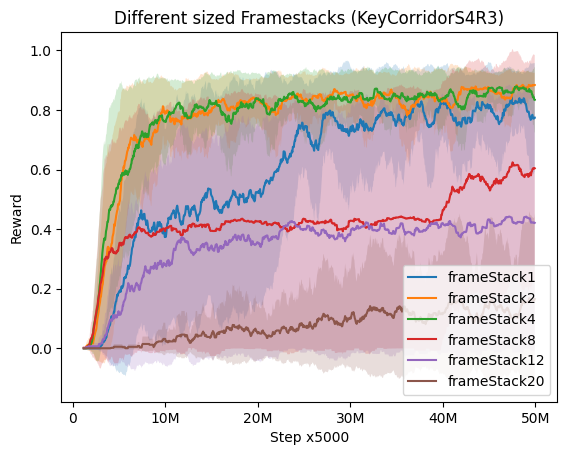

In [57]:
SMOOTHING = 25
frame = {
    "frameStack1": [],
    "frameStack2": [],
    "frameStack4": [],
    "frameStack8": [],
    "frameStack12": [],
    "frameStack20": [],
}
mean_std = {}

csv_files = get_csv_files(os.path.join(DATA_FOLDER, "framestack"))
for csv_file in csv_files:
    for key in reversed(frame.keys()):
        if key in csv_file:
            frame[key].append(pd.read_csv(csv_file, header=0, names=["wall_time", "step", "reward"])["reward"])
            break

mean_std = {}
for key, value in frame.items():
    mean_std[key] = (
        pd.Series(np.mean(value, axis=0)).rolling(SMOOTHING).mean(),
        pd.Series(np.std(value, axis=0)).rolling(SMOOTHING).mean()
    )
# plt.figure(figsize=(10, 10))
for key, value in mean_std.items():
    plt.plot(value[0], label=key)
    plt.fill_between(range(len(value[0])),value[0] - value[1],value[0] + value[1],alpha=0.2)
plt.legend()
plt.ylabel("Reward")
plt.xlabel("Step x5000")
plt.xticks(*tick_labels["Framestack_KeyCorrS4R3"])
plt.title("Different sized Framestacks (KeyCorridorS4R3)")
plt.show()